In [1]:
import pandas as pd
import numpy as np
import talib
import pyrenko
import datetime as dt
from logging import Logger
from catalyst import run_algorithm
from catalyst.api import symbol, order,order_target_percent, get_datetime, record, get_open_orders
from catalyst.exchange.utils.stats_utils import extract_transactions
import warnings
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%load_ext catalyst

In [3]:
NAMESPACE = 'RenkoBB'
log = Logger(NAMESPACE)

In [4]:
def initialize(context):
    context.i = 0
    context.asset = symbol('btc_usdt')
    context.tf = '1H'
    context.atr_time = 51
    context.bb = 6
    context.model = pyrenko.renko()
    
    context.close_trigger = [1, -1, -1]
    context.open_trigger = [-1, 1, 1]


In [5]:
def handle_data(context, data):
    
    current_time = get_datetime().time()
    if current_time.hour == 0 and current_time.minute == 0:
        print('Current date is ' + str(get_datetime().date()))
        
    context.i+=1
    if context.i < context.atr_time:
        return
    
    
    if not data.can_trade(context.asset):
        return
    
    current = data.current(context.asset, 'close')
    price = data.current(context.asset,'price')

    last_price = data.history(context.asset,
                                'price',
                                bar_count = context.atr_time - 1, 
                                frequency = context.tf
                                )
    
    
    bb_data = data.history(context.asset,
                                  'close',
                                  bar_count=context.bb,
                                  frequency=context.tf)

    hlc_data = data.history(context.asset,
                                   fields=['high', 'low', 'close'],
                                   bar_count=context.atr_time,
                                   frequency=context.tf)

    upperband, middleband, lowerband = talib.BBANDS(bb_data, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    upperband, middleband, lowerband = upperband[-1], middleband[-1], lowerband[-1]
    bb_range = upperband - lowerband

    record(price=price,
               cash=context.portfolio.cash,
               upperband=upperband,
               middleband=middleband,
               lowerband=lowerband)
        

    context.model = pyrenko.renko()
    optimal_brick = context.model.set_brick_size(HLC_history=hlc_data)
    context.model.build_history(prices = last_price)
    
    prev_dir = context.model.get_renko_directions()
    last_dir = prev_dir[-4:-1]
    
#     print('1 open',len(get_open_orders(context.asset)))
#     print('2 open', len(context.blotter.open_orders))
    
    if len(context.blotter.open_orders) == 0:

        
        if last_dir == context.open_trigger and bb_range > 500:
            order_target_percent(context.asset, 0.1, limit_price=current)
            print('Position opened') 
            
    elif len(context.blotter.open_orders) > 0:
    
        if last_dir == context.close_trigger:
            print('Position closed')
            order_target_percenter(context.asset, 0, limit_price=current)
            context.model = pyrenko.renko()


In [6]:
def analyze(context, perf):
    print('Total return: ' + str(perf.algorithm_period_return[-1]))
    print('Sortino coef: ' + str(perf.sortino[-1]))
    print('Max drawdown: ' + str(np.min(perf.max_drawdown)))
    print('Alpha: ' + str(perf.alpha[-1]))
    print('Beta: ' + str(perf.beta[-1]))
    
    
    matplotlib.rc('figure', figsize=(25, 10))

    exchange = list(context.exchanges.values())[0]
    quote_currency = exchange.quote_currency.upper()
    
    ax1 = plt.subplot(311)
    perf.loc[:, ['price', 'upperband', 'middleband', 'lowerband']].plot(
        ax=ax1,
        label='Price')

    ax1.set_ylabel('{asset}\n({quote})'.format(
        asset=context.asset.symbol,
        quote=quote_currency
    ))
    start, end = ax1.get_ylim()
    ax1.yaxis.set_ticks(np.arange(start, end, (end - start) / 5))
    
    ax2 = plt.subplot(312)
    perf.loc[:, 'portfolio_value'].plot(ax=ax2)
    ax2.set_ylabel('Portfolio\nValue\n({})'.format(quote_currency))

    # Plot the price increase or decrease over time.
    ax3 = plt.subplot(313)
    perf.loc[:, 'price'].plot(ax=ax3, label='Price')

    ax3.set_ylabel('{asset}\n({quote})'.format(
        asset=context.asset.symbol, quote=quote_currency
    ))

    transaction_df = extract_transactions(perf)
    if not transaction_df.empty:
        buy_df = transaction_df[transaction_df['amount'] > 0]
        sell_df = transaction_df[transaction_df['amount'] < 0]
        ax3.scatter(
            buy_df.index.to_pydatetime(),
            perf.loc[buy_df.index.floor('1 min'), 'price'],
            marker='^',
            s=100,
            c='green',
            label=''
        )
        ax3.scatter(
            sell_df.index.to_pydatetime(),
            perf.loc[sell_df.index.floor('1 min'), 'price'],
            marker='v',
            s=100,
            c='red',
            label=''
        )

[2019-10-04 20:06:28.865589] INFO: run_algo: Catalyst version 0.5.21
[2019-10-04 20:06:28.866373] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-10-04 20:06:31.870141] INFO: run_algo: running algo in backtest mode
[2019-10-04 20:06:32.195882] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2019-10-04 20:06:32.552148] INFO: exchange_blotter: order has not reached the trigger at current price 13581.56
[2019-10-04 20:06:32.575357] INFO: exchange_blotter: order has not reached the trigger at current price 13598.99
[2019-10-04 20:06:32.597936] INFO: exchange_blotter: order has not reached the trigger at current price 13548.2
[2019-10-04 20:06:32.638462] INFO: exchange_blotter: order has not reached the trigger at current price 13531.7


Current date is 2018-01-01
Position opened
Position opened
Position opened


[2019-10-04 20:06:32.700855] INFO: exchange_blotter: order has not reached the trigger at current price 13471.61
[2019-10-04 20:06:32.722793] INFO: exchange_blotter: order has not reached the trigger at current price 13529.01
[2019-10-04 20:06:32.745896] INFO: exchange_blotter: order has not reached the trigger at current price 13543.87
[2019-10-04 20:06:32.767894] INFO: exchange_blotter: order has not reached the trigger at current price 13530.98
[2019-10-04 20:06:32.790380] INFO: exchange_blotter: order has not reached the trigger at current price 13530.98
[2019-10-04 20:06:32.812968] INFO: exchange_blotter: order has not reached the trigger at current price 13520.89
[2019-10-04 20:06:32.835113] INFO: exchange_blotter: order has not reached the trigger at current price 13510.85
[2019-10-04 20:06:32.860325] INFO: exchange_blotter: order has not reached the trigger at current price 13510.85


Position opened
Position opened


[2019-10-04 20:06:32.887626] INFO: exchange_blotter: order has not reached the trigger at current price 13500.98
[2019-10-04 20:06:32.914546] INFO: exchange_blotter: order has not reached the trigger at current price 13480.01
[2019-10-04 20:06:32.986026] INFO: exchange_blotter: order has not reached the trigger at current price 13469.99
[2019-10-04 20:06:33.007448] INFO: exchange_blotter: order has not reached the trigger at current price 13478.98
[2019-10-04 20:06:33.024957] INFO: exchange_blotter: order has not reached the trigger at current price 13445.630000000001
[2019-10-04 20:06:33.047200] INFO: exchange_blotter: order has not reached the trigger at current price 13445.630000000001
[2019-10-04 20:06:33.064858] INFO: exchange_blotter: order has not reached the trigger at current price 13468.0
[2019-10-04 20:06:33.085186] INFO: exchange_blotter: order has not reached the trigger at current price 13469.99
[2019-10-04 20:06:33.109045] INFO: exchange_blotter: order has not reached th

Position opened
Position opened
Position opened


[2019-10-04 20:06:33.173616] INFO: exchange_blotter: order has not reached the trigger at current price 13578.0
[2019-10-04 20:06:33.191938] INFO: exchange_blotter: order has not reached the trigger at current price 13560.91
[2019-10-04 20:06:33.213477] INFO: exchange_blotter: order has not reached the trigger at current price 13562.65
[2019-10-04 20:06:33.232035] INFO: exchange_blotter: order has not reached the trigger at current price 13586.0
[2019-10-04 20:06:33.249381] INFO: exchange_blotter: order has not reached the trigger at current price 13541.2
[2019-10-04 20:06:33.274749] INFO: exchange_blotter: order has not reached the trigger at current price 13568.86
[2019-10-04 20:06:33.298631] INFO: exchange_blotter: order has not reached the trigger at current price 13568.27
[2019-10-04 20:06:33.320416] INFO: exchange_blotter: order has not reached the trigger at current price 13575.0
[2019-10-04 20:06:33.337439] INFO: exchange_blotter: order has not reached the trigger at current pr

Position opened
Position opened
Position opened
Position opened
Position opened
Position opened
Position opened


[2019-10-04 20:06:33.944777] INFO: exchange_blotter: order has not reached the trigger at current price 13203.06
[2019-10-04 20:06:33.962427] INFO: exchange_blotter: order has not reached the trigger at current price 13280.28
[2019-10-04 20:06:33.981729] INFO: exchange_blotter: order has not reached the trigger at current price 13317.19
[2019-10-04 20:06:34.003063] INFO: exchange_blotter: order has not reached the trigger at current price 13317.34
[2019-10-04 20:06:34.020497] INFO: exchange_blotter: order has not reached the trigger at current price 13345.0
[2019-10-04 20:06:34.041933] INFO: exchange_blotter: order has not reached the trigger at current price 13366.0
[2019-10-04 20:06:34.059626] INFO: exchange_blotter: order has not reached the trigger at current price 13400.0
[2019-10-04 20:06:34.080172] INFO: exchange_blotter: order has not reached the trigger at current price 13350.5
[2019-10-04 20:06:34.104703] INFO: exchange_blotter: order has not reached the trigger at current pr

Position opened
Position opened


[2019-10-04 20:06:34.146297] INFO: exchange_blotter: order has not reached the trigger at current price 13320.0
[2019-10-04 20:06:34.163699] INFO: exchange_blotter: order has not reached the trigger at current price 13352.45
[2019-10-04 20:06:34.185234] INFO: exchange_blotter: order has not reached the trigger at current price 13350.69
[2019-10-04 20:06:34.204002] INFO: exchange_blotter: order has not reached the trigger at current price 13351.380000000001
[2019-10-04 20:06:34.222361] INFO: exchange_blotter: order has not reached the trigger at current price 13360.0
[2019-10-04 20:06:34.248891] INFO: exchange_blotter: order has not reached the trigger at current price 13387.0
[2019-10-04 20:06:34.273023] INFO: exchange_blotter: order has not reached the trigger at current price 13364.77
[2019-10-04 20:06:34.296715] INFO: exchange_blotter: order has not reached the trigger at current price 13343.03
[2019-10-04 20:06:34.324008] INFO: exchange_blotter: order has not reached the trigger at

[2019-10-04 20:06:35.633815] INFO: exchange_blotter: order has not reached the trigger at current price 13505.0
[2019-10-04 20:06:35.650447] INFO: exchange_blotter: order has not reached the trigger at current price 13505.0
[2019-10-04 20:06:35.670431] INFO: exchange_blotter: order has not reached the trigger at current price 13510.0
[2019-10-04 20:06:35.690445] INFO: exchange_blotter: order has not reached the trigger at current price 13541.880000000001
[2019-10-04 20:06:35.710440] INFO: exchange_blotter: order has not reached the trigger at current price 13559.0
[2019-10-04 20:06:35.730575] INFO: exchange_blotter: order has not reached the trigger at current price 13544.24
[2019-10-04 20:06:35.750723] INFO: exchange_blotter: order has not reached the trigger at current price 13560.95
[2019-10-04 20:06:35.770609] INFO: exchange_blotter: order has not reached the trigger at current price 13562.37
[2019-10-04 20:06:35.790394] INFO: exchange_blotter: order has not reached the trigger at 

[2019-10-04 20:06:37.190524] INFO: exchange_blotter: order has not reached the trigger at current price 13445.35
[2019-10-04 20:06:37.211918] INFO: exchange_blotter: order has not reached the trigger at current price 13457.800000000001
[2019-10-04 20:06:37.233368] INFO: exchange_blotter: order has not reached the trigger at current price 13470.18
[2019-10-04 20:06:37.257474] INFO: exchange_blotter: order has not reached the trigger at current price 13462.99
[2019-10-04 20:06:37.281615] INFO: exchange_blotter: order has not reached the trigger at current price 13461.99
[2019-10-04 20:06:37.306037] INFO: exchange_blotter: order has not reached the trigger at current price 13462.0
[2019-10-04 20:06:37.329690] INFO: exchange_blotter: order has not reached the trigger at current price 13479.06
[2019-10-04 20:06:37.355710] INFO: exchange_blotter: order has not reached the trigger at current price 13500.0
[2019-10-04 20:06:37.382228] INFO: exchange_blotter: order has not reached the trigger a

[2019-10-04 20:06:38.843573] INFO: exchange_blotter: order has not reached the trigger at current price 13559.69
[2019-10-04 20:06:38.864011] INFO: exchange_blotter: order has not reached the trigger at current price 13549.85
[2019-10-04 20:06:38.883668] INFO: exchange_blotter: order has not reached the trigger at current price 13540.98
[2019-10-04 20:06:38.906872] INFO: exchange_blotter: order has not reached the trigger at current price 13540.0
[2019-10-04 20:06:38.930742] INFO: exchange_blotter: order has not reached the trigger at current price 13532.1
[2019-10-04 20:06:38.955198] INFO: exchange_blotter: order has not reached the trigger at current price 13559.99
[2019-10-04 20:06:38.978739] INFO: exchange_blotter: order has not reached the trigger at current price 13541.0
[2019-10-04 20:06:39.004693] INFO: exchange_blotter: order has not reached the trigger at current price 13538.59
[2019-10-04 20:06:39.031167] INFO: exchange_blotter: order has not reached the trigger at current p

[2019-10-04 20:06:40.422285] INFO: exchange_blotter: order has not reached the trigger at current price 13738.98
[2019-10-04 20:06:40.443885] INFO: exchange_blotter: order has not reached the trigger at current price 13770.99
[2019-10-04 20:06:40.461516] INFO: exchange_blotter: order has not reached the trigger at current price 13770.0
[2019-10-04 20:06:40.481464] INFO: exchange_blotter: order has not reached the trigger at current price 13770.02
[2019-10-04 20:06:40.498974] INFO: exchange_blotter: order has not reached the trigger at current price 13770.02
[2019-10-04 20:06:40.517480] INFO: exchange_blotter: order has not reached the trigger at current price 13774.83
[2019-10-04 20:06:40.539258] INFO: exchange_blotter: order has not reached the trigger at current price 13788.98
[2019-10-04 20:06:40.560188] INFO: exchange_blotter: order has not reached the trigger at current price 13800.0
[2019-10-04 20:06:40.577012] INFO: exchange_blotter: order has not reached the trigger at current 

[2019-10-04 20:06:41.985449] INFO: exchange_blotter: order has not reached the trigger at current price 13611.960000000001
[2019-10-04 20:06:42.005665] INFO: exchange_blotter: order has not reached the trigger at current price 13636.06
[2019-10-04 20:06:42.025397] INFO: exchange_blotter: order has not reached the trigger at current price 13656.23
[2019-10-04 20:06:42.044900] INFO: exchange_blotter: order has not reached the trigger at current price 13610.27
[2019-10-04 20:06:42.061914] INFO: exchange_blotter: order has not reached the trigger at current price 13641.0
[2019-10-04 20:06:42.080983] INFO: exchange_blotter: order has not reached the trigger at current price 13681.01
[2019-10-04 20:06:42.100054] INFO: exchange_blotter: order has not reached the trigger at current price 13695.0
[2019-10-04 20:06:42.117042] INFO: exchange_blotter: order has not reached the trigger at current price 13689.64
[2019-10-04 20:06:42.136013] INFO: exchange_blotter: order has not reached the trigger a

[2019-10-04 20:06:43.469524] INFO: exchange_blotter: order has not reached the trigger at current price 13598.11
[2019-10-04 20:06:43.491119] INFO: exchange_blotter: order has not reached the trigger at current price 13580.74
[2019-10-04 20:06:43.513955] INFO: exchange_blotter: order has not reached the trigger at current price 13580.0
[2019-10-04 20:06:43.533758] INFO: exchange_blotter: order has not reached the trigger at current price 13542.0
[2019-10-04 20:06:43.555125] INFO: exchange_blotter: order has not reached the trigger at current price 13549.77
[2019-10-04 20:06:43.574673] INFO: exchange_blotter: order has not reached the trigger at current price 13544.98
[2019-10-04 20:06:43.597538] INFO: exchange_blotter: order has not reached the trigger at current price 13558.78
[2019-10-04 20:06:43.616560] INFO: exchange_blotter: order has not reached the trigger at current price 13538.98
[2019-10-04 20:06:43.638764] INFO: exchange_blotter: order has not reached the trigger at current 

[2019-10-04 20:06:44.927582] INFO: exchange_blotter: order has not reached the trigger at current price 13550.960000000001
[2019-10-04 20:06:44.952119] INFO: exchange_blotter: order has not reached the trigger at current price 13546.06
[2019-10-04 20:06:44.977219] INFO: exchange_blotter: order has not reached the trigger at current price 13555.85
[2019-10-04 20:06:44.995924] INFO: exchange_blotter: order has not reached the trigger at current price 13568.07
[2019-10-04 20:06:45.013771] INFO: exchange_blotter: order has not reached the trigger at current price 13577.02
[2019-10-04 20:06:45.034987] INFO: exchange_blotter: order has not reached the trigger at current price 13582.960000000001
[2019-10-04 20:06:45.051882] INFO: exchange_blotter: order has not reached the trigger at current price 13586.51
[2019-10-04 20:06:45.071611] INFO: exchange_blotter: order has not reached the trigger at current price 13545.99
[2019-10-04 20:06:45.092271] INFO: exchange_blotter: order has not reached t

Position opened
Position opened
Position opened


[2019-10-04 20:06:45.784847] INFO: exchange_blotter: order has not reached the trigger at current price 13147.0
[2019-10-04 20:06:45.806179] INFO: exchange_blotter: order has not reached the trigger at current price 13145.08
[2019-10-04 20:06:45.827176] INFO: exchange_blotter: order has not reached the trigger at current price 13123.87
[2019-10-04 20:06:45.846196] INFO: exchange_blotter: order has not reached the trigger at current price 13157.470000000001
[2019-10-04 20:06:45.867982] INFO: exchange_blotter: order has not reached the trigger at current price 13142.57
[2019-10-04 20:06:45.888232] INFO: exchange_blotter: order has not reached the trigger at current price 13150.0
[2019-10-04 20:06:45.911672] INFO: exchange_blotter: order has not reached the trigger at current price 13159.98
[2019-10-04 20:06:45.967742] INFO: exchange_blotter: order has not reached the trigger at current price 13154.37
[2019-10-04 20:06:45.988409] INFO: exchange_blotter: order has not reached the trigger a

Position opened
Position opened


[2019-10-04 20:06:46.155059] INFO: exchange_blotter: order has not reached the trigger at current price 13156.23
[2019-10-04 20:06:46.175993] INFO: exchange_blotter: order has not reached the trigger at current price 13173.76
[2019-10-04 20:06:46.195287] INFO: exchange_blotter: order has not reached the trigger at current price 13173.76
[2019-10-04 20:06:46.216516] INFO: exchange_blotter: order has not reached the trigger at current price 13120.0
[2019-10-04 20:06:46.235669] INFO: exchange_blotter: order has not reached the trigger at current price 13132.0
[2019-10-04 20:06:46.258516] INFO: exchange_blotter: order has not reached the trigger at current price 13103.76
[2019-10-04 20:06:46.281979] INFO: exchange_blotter: order has not reached the trigger at current price 13125.98
[2019-10-04 20:06:46.304236] INFO: exchange_blotter: order has not reached the trigger at current price 13130.69
[2019-10-04 20:06:46.323563] INFO: exchange_blotter: order has not reached the trigger at current 

[2019-10-04 20:06:47.620069] INFO: exchange_blotter: order has not reached the trigger at current price 13202.92
[2019-10-04 20:06:47.638033] INFO: exchange_blotter: order has not reached the trigger at current price 13219.970000000001
[2019-10-04 20:06:47.658454] INFO: exchange_blotter: order has not reached the trigger at current price 13218.9
[2019-10-04 20:06:47.680618] INFO: exchange_blotter: order has not reached the trigger at current price 13169.0
[2019-10-04 20:06:47.698641] INFO: exchange_blotter: order has not reached the trigger at current price 13152.0
[2019-10-04 20:06:47.719338] INFO: exchange_blotter: order has not reached the trigger at current price 13151.98
[2019-10-04 20:06:47.738077] INFO: exchange_blotter: order has not reached the trigger at current price 13117.77
[2019-10-04 20:06:47.755935] INFO: exchange_blotter: order has not reached the trigger at current price 13172.42
[2019-10-04 20:06:47.777477] INFO: exchange_blotter: order has not reached the trigger at

Position opened
Position opened
Position opened
Position opened
Position opened
Position opened
Position opened
Position opened


[2019-10-04 20:06:48.062935] INFO: exchange_blotter: order has not reached the trigger at current price 12988.9
[2019-10-04 20:06:48.083856] INFO: exchange_blotter: order has not reached the trigger at current price 12999.99
[2019-10-04 20:06:48.101132] INFO: exchange_blotter: order has not reached the trigger at current price 13029.0
[2019-10-04 20:06:48.122168] INFO: exchange_blotter: order has not reached the trigger at current price 13029.0
[2019-10-04 20:06:48.162715] INFO: exchange_blotter: order has not reached the trigger at current price 13028.0
[2019-10-04 20:06:48.184411] INFO: exchange_blotter: order has not reached the trigger at current price 13032.0
[2019-10-04 20:06:48.221509] INFO: exchange_blotter: order has not reached the trigger at current price 13040.0
[2019-10-04 20:06:48.240898] INFO: exchange_blotter: order has not reached the trigger at current price 12991.0
[2019-10-04 20:06:48.259099] INFO: exchange_blotter: order has not reached the trigger at current price

Position opened
Position opened


[2019-10-04 20:06:48.374177] INFO: exchange_blotter: order has not reached the trigger at current price 12969.98
[2019-10-04 20:06:48.394756] INFO: exchange_blotter: order has not reached the trigger at current price 12950.0
[2019-10-04 20:06:48.416641] INFO: exchange_blotter: order has not reached the trigger at current price 12950.0
[2019-10-04 20:06:48.436415] INFO: exchange_blotter: order has not reached the trigger at current price 12930.36
[2019-10-04 20:06:48.454173] INFO: exchange_blotter: order has not reached the trigger at current price 12944.29
[2019-10-04 20:06:48.471798] INFO: exchange_blotter: order has not reached the trigger at current price 12972.99
[2019-10-04 20:06:48.492180] INFO: exchange_blotter: order has not reached the trigger at current price 13015.29
[2019-10-04 20:06:48.509028] INFO: exchange_blotter: order has not reached the trigger at current price 13034.16
[2019-10-04 20:06:48.582634] INFO: exchange_blotter: order has not reached the trigger at current 

Position opened
Position opened
Position opened
Position opened


[2019-10-04 20:06:48.751885] INFO: exchange_blotter: order has not reached the trigger at current price 12971.470000000001
[2019-10-04 20:06:48.768096] INFO: exchange_blotter: order has not reached the trigger at current price 12954.98
[2019-10-04 20:06:48.787825] INFO: exchange_blotter: order has not reached the trigger at current price 12968.51
[2019-10-04 20:06:48.808514] INFO: exchange_blotter: order has not reached the trigger at current price 12999.69
[2019-10-04 20:06:48.827756] INFO: exchange_blotter: order has not reached the trigger at current price 12999.0
[2019-10-04 20:06:48.847781] INFO: exchange_blotter: order has not reached the trigger at current price 12979.98
[2019-10-04 20:06:48.867916] INFO: exchange_blotter: order has not reached the trigger at current price 12993.99
[2019-10-04 20:06:48.887951] INFO: exchange_blotter: order has not reached the trigger at current price 13017.0
[2019-10-04 20:06:48.904693] INFO: exchange_blotter: order has not reached the trigger a

Position opened
Position opened
Position opened
Position opened
Position opened
Position opened


[2019-10-04 20:06:50.139356] INFO: exchange_blotter: order has not reached the trigger at current price 13140.99
[2019-10-04 20:06:50.158716] INFO: exchange_blotter: order has not reached the trigger at current price 13149.93
[2019-10-04 20:06:50.179264] INFO: exchange_blotter: order has not reached the trigger at current price 13150.0
[2019-10-04 20:06:50.197878] INFO: exchange_blotter: order has not reached the trigger at current price 13178.970000000001
[2019-10-04 20:06:50.215123] INFO: exchange_blotter: order has not reached the trigger at current price 13183.23
[2019-10-04 20:06:50.236552] INFO: exchange_blotter: order has not reached the trigger at current price 13221.03
[2019-10-04 20:06:50.256074] INFO: exchange_blotter: order has not reached the trigger at current price 13217.720000000001
[2019-10-04 20:06:50.276875] INFO: exchange_blotter: order has not reached the trigger at current price 13200.0
[2019-10-04 20:06:50.297079] INFO: exchange_blotter: order has not reached the

Position opened
Position opened
Position opened
Position opened
Position opened
Position opened
Position opened


[2019-10-04 20:06:54.936465] INFO: exchange_blotter: order has not reached the trigger at current price 13419.53
[2019-10-04 20:06:54.972294] INFO: exchange_blotter: order has not reached the trigger at current price 13423.08
[2019-10-04 20:06:54.991262] INFO: exchange_blotter: order has not reached the trigger at current price 13388.86
[2019-10-04 20:06:55.010039] INFO: exchange_blotter: order has not reached the trigger at current price 13382.62
[2019-10-04 20:06:55.029520] INFO: exchange_blotter: order has not reached the trigger at current price 13377.57
[2019-10-04 20:06:55.049509] INFO: exchange_blotter: order has not reached the trigger at current price 13386.01
[2019-10-04 20:06:55.069860] INFO: exchange_blotter: order has not reached the trigger at current price 13398.98
[2019-10-04 20:06:55.091355] INFO: exchange_blotter: order has not reached the trigger at current price 13379.0
[2019-10-04 20:06:55.110065] INFO: exchange_blotter: order has not reached the trigger at current

Position opened


[2019-10-04 20:06:55.226206] INFO: exchange_blotter: order has not reached the trigger at current price 13458.36
[2019-10-04 20:06:55.245782] INFO: exchange_blotter: order has not reached the trigger at current price 13430.0
[2019-10-04 20:06:55.266106] INFO: exchange_blotter: order has not reached the trigger at current price 13427.9
[2019-10-04 20:06:55.285608] INFO: exchange_blotter: order has not reached the trigger at current price 13430.0
[2019-10-04 20:06:55.301631] INFO: exchange_blotter: order has not reached the trigger at current price 13413.94
[2019-10-04 20:06:55.319469] INFO: exchange_blotter: order has not reached the trigger at current price 13449.99
[2019-10-04 20:06:55.341330] INFO: exchange_blotter: order has not reached the trigger at current price 13449.970000000001
[2019-10-04 20:06:55.358189] INFO: exchange_blotter: order has not reached the trigger at current price 13426.16
[2019-10-04 20:06:55.377744] INFO: exchange_blotter: order has not reached the trigger at

Position opened
Position opened


[2019-10-04 20:06:55.416024] INFO: exchange_blotter: order has not reached the trigger at current price 13451.91
[2019-10-04 20:06:55.436779] INFO: exchange_blotter: order has not reached the trigger at current price 13451.95
[2019-10-04 20:06:55.473180] INFO: exchange_blotter: order has not reached the trigger at current price 13443.0
[2019-10-04 20:06:55.492356] INFO: exchange_blotter: order has not reached the trigger at current price 13443.01
[2019-10-04 20:06:55.512274] INFO: exchange_blotter: order has not reached the trigger at current price 13440.24
[2019-10-04 20:06:55.529767] INFO: exchange_blotter: order has not reached the trigger at current price 13439.99
[2019-10-04 20:06:55.549685] INFO: exchange_blotter: order has not reached the trigger at current price 13426.16
[2019-10-04 20:06:55.569309] INFO: exchange_blotter: order has not reached the trigger at current price 13395.29
[2019-10-04 20:06:55.589308] INFO: exchange_blotter: order has not reached the trigger at current

Position opened


[2019-10-04 20:06:55.684165] INFO: exchange_blotter: order has not reached the trigger at current price 13410.09
[2019-10-04 20:06:55.701320] INFO: exchange_blotter: order has not reached the trigger at current price 13418.86
[2019-10-04 20:06:55.722050] INFO: exchange_blotter: order has not reached the trigger at current price 13417.970000000001
[2019-10-04 20:06:55.743968] INFO: exchange_blotter: order has not reached the trigger at current price 13399.24
[2019-10-04 20:06:55.764214] INFO: exchange_blotter: order has not reached the trigger at current price 13399.23
[2019-10-04 20:06:55.784743] INFO: exchange_blotter: order has not reached the trigger at current price 13416.81
[2019-10-04 20:06:55.801969] INFO: exchange_blotter: order has not reached the trigger at current price 13435.0


Current date is 2018-01-02


[2019-10-04 20:07:15.251054] INFO: exchange_blotter: order has not reached the trigger at current price 14550.03
[2019-10-04 20:07:15.272094] INFO: exchange_blotter: order has not reached the trigger at current price 14562.01
[2019-10-04 20:07:15.291454] INFO: exchange_blotter: order has not reached the trigger at current price 14560.0
[2019-10-04 20:07:15.311638] INFO: exchange_blotter: order has not reached the trigger at current price 14589.54


Position opened
Position opened
Position opened
Position opened
Position opened
Position opened
Position opened
Position opened


[2019-10-04 20:07:15.426137] INFO: exchange_blotter: order has not reached the trigger at current price 14661.99
[2019-10-04 20:07:15.445694] INFO: exchange_blotter: order has not reached the trigger at current price 14734.0
[2019-10-04 20:07:15.465403] INFO: exchange_blotter: order has not reached the trigger at current price 14632.0
[2019-10-04 20:07:15.518034] INFO: exchange_blotter: order has not reached the trigger at current price 14462.550000000001
[2019-10-04 20:07:15.540536] INFO: exchange_blotter: order has not reached the trigger at current price 14525.18
[2019-10-04 20:07:15.562917] INFO: exchange_blotter: order has not reached the trigger at current price 14589.85
[2019-10-04 20:07:15.584407] INFO: exchange_blotter: order has not reached the trigger at current price 14545.04
[2019-10-04 20:07:15.605118] INFO: exchange_blotter: order has not reached the trigger at current price 14560.78


Position opened
Position opened
Position opened


[2019-10-04 20:07:15.626828] INFO: exchange_blotter: order has not reached the trigger at current price 14620.0
[2019-10-04 20:07:15.648894] INFO: exchange_blotter: order has not reached the trigger at current price 14624.02
[2019-10-04 20:07:15.670032] INFO: exchange_blotter: order has not reached the trigger at current price 14580.0
[2019-10-04 20:07:15.692553] INFO: exchange_blotter: order has not reached the trigger at current price 14599.99
[2019-10-04 20:07:15.712419] INFO: exchange_blotter: order has not reached the trigger at current price 14540.970000000001
[2019-10-04 20:07:15.732053] INFO: exchange_blotter: order has not reached the trigger at current price 14535.62
[2019-10-04 20:07:15.757394] INFO: exchange_blotter: order has not reached the trigger at current price 14545.5
[2019-10-04 20:07:15.776063] INFO: exchange_blotter: order has not reached the trigger at current price 14548.99
[2019-10-04 20:07:15.797964] INFO: exchange_blotter: order has not reached the trigger at

[2019-10-04 20:07:17.101188] INFO: exchange_blotter: order has not reached the trigger at current price 14960.02
[2019-10-04 20:07:17.123085] INFO: exchange_blotter: order has not reached the trigger at current price 15054.93
[2019-10-04 20:07:17.140345] INFO: exchange_blotter: order has not reached the trigger at current price 15095.35
[2019-10-04 20:07:17.159618] INFO: exchange_blotter: order has not reached the trigger at current price 15083.25
[2019-10-04 20:07:17.179560] INFO: exchange_blotter: order has not reached the trigger at current price 15059.94
[2019-10-04 20:07:17.199693] INFO: exchange_blotter: order has not reached the trigger at current price 14999.92
[2019-10-04 20:07:17.219056] INFO: exchange_blotter: order has not reached the trigger at current price 14900.02
[2019-10-04 20:07:17.236454] INFO: exchange_blotter: order has not reached the trigger at current price 14999.99
[2019-10-04 20:07:17.256394] INFO: exchange_blotter: order has not reached the trigger at curren

[2019-10-04 20:07:18.500330] INFO: exchange_blotter: order has not reached the trigger at current price 14759.0
[2019-10-04 20:07:18.520654] INFO: exchange_blotter: order has not reached the trigger at current price 14776.050000000001
[2019-10-04 20:07:18.540543] INFO: exchange_blotter: order has not reached the trigger at current price 14760.0
[2019-10-04 20:07:18.559825] INFO: exchange_blotter: order has not reached the trigger at current price 14763.54
[2019-10-04 20:07:18.579258] INFO: exchange_blotter: order has not reached the trigger at current price 14728.7
[2019-10-04 20:07:18.600712] INFO: exchange_blotter: order has not reached the trigger at current price 14660.26
[2019-10-04 20:07:18.618850] INFO: exchange_blotter: order has not reached the trigger at current price 14636.06
[2019-10-04 20:07:18.637869] INFO: exchange_blotter: order has not reached the trigger at current price 14600.0
[2019-10-04 20:07:18.657666] INFO: exchange_blotter: order has not reached the trigger at 

[2019-10-04 20:07:19.895167] INFO: exchange_blotter: order has not reached the trigger at current price 14763.03
[2019-10-04 20:07:19.912918] INFO: exchange_blotter: order has not reached the trigger at current price 14779.0
[2019-10-04 20:07:19.934494] INFO: exchange_blotter: order has not reached the trigger at current price 14765.0
[2019-10-04 20:07:19.955822] INFO: exchange_blotter: order has not reached the trigger at current price 14778.98
[2019-10-04 20:07:19.973508] INFO: exchange_blotter: order has not reached the trigger at current price 14779.01
[2019-10-04 20:07:19.993430] INFO: exchange_blotter: order has not reached the trigger at current price 14791.380000000001
[2019-10-04 20:07:20.010827] INFO: exchange_blotter: order has not reached the trigger at current price 14745.69
[2019-10-04 20:07:20.030806] INFO: exchange_blotter: order has not reached the trigger at current price 14774.89
[2019-10-04 20:07:20.052630] INFO: exchange_blotter: order has not reached the trigger a

[2019-10-04 20:07:21.285298] INFO: exchange_blotter: order has not reached the trigger at current price 14800.0
[2019-10-04 20:07:21.305218] INFO: exchange_blotter: order has not reached the trigger at current price 14867.99
[2019-10-04 20:07:21.322406] INFO: exchange_blotter: order has not reached the trigger at current price 14840.15
[2019-10-04 20:07:21.343462] INFO: exchange_blotter: order has not reached the trigger at current price 14805.970000000001
[2019-10-04 20:07:21.361088] INFO: exchange_blotter: order has not reached the trigger at current price 14786.03
[2019-10-04 20:07:21.381623] INFO: exchange_blotter: order has not reached the trigger at current price 14790.94
[2019-10-04 20:07:21.401567] INFO: exchange_blotter: order has not reached the trigger at current price 14779.31
[2019-10-04 20:07:21.421246] INFO: exchange_blotter: order has not reached the trigger at current price 14755.09
[2019-10-04 20:07:21.438086] INFO: exchange_blotter: order has not reached the trigger 

Current date is 2018-01-03


[2019-10-04 20:07:21.751575] INFO: exchange_blotter: order has not reached the trigger at current price 14763.0
[2019-10-04 20:07:21.769098] INFO: exchange_blotter: order has not reached the trigger at current price 14772.99
[2019-10-04 20:07:21.790820] INFO: exchange_blotter: order has not reached the trigger at current price 14714.0
[2019-10-04 20:07:21.808783] INFO: exchange_blotter: order has not reached the trigger at current price 14725.34
[2019-10-04 20:07:21.829548] INFO: exchange_blotter: order has not reached the trigger at current price 14750.01
[2019-10-04 20:07:21.850833] INFO: exchange_blotter: order has not reached the trigger at current price 14765.0
[2019-10-04 20:07:21.868044] INFO: exchange_blotter: order has not reached the trigger at current price 14785.050000000001
[2019-10-04 20:07:21.886770] INFO: exchange_blotter: order has not reached the trigger at current price 14840.0
[2019-10-04 20:07:21.906152] INFO: exchange_blotter: order has not reached the trigger at 

[2019-10-04 20:07:23.186469] INFO: exchange_blotter: order has not reached the trigger at current price 14735.03
[2019-10-04 20:07:23.207460] INFO: exchange_blotter: order has not reached the trigger at current price 14705.0
[2019-10-04 20:07:23.229503] INFO: exchange_blotter: order has not reached the trigger at current price 14705.02
[2019-10-04 20:07:23.254787] INFO: exchange_blotter: order has not reached the trigger at current price 14695.0
[2019-10-04 20:07:23.277132] INFO: exchange_blotter: order has not reached the trigger at current price 14706.75
[2019-10-04 20:07:23.294875] INFO: exchange_blotter: order has not reached the trigger at current price 14730.0
[2019-10-04 20:07:23.312368] INFO: exchange_blotter: order has not reached the trigger at current price 14729.710000000001
[2019-10-04 20:07:23.331194] INFO: exchange_blotter: order has not reached the trigger at current price 14709.54
[2019-10-04 20:07:23.347755] INFO: exchange_blotter: order has not reached the trigger at

[2019-10-04 20:07:24.644799] INFO: exchange_blotter: order has not reached the trigger at current price 14793.7
[2019-10-04 20:07:24.665197] INFO: exchange_blotter: order has not reached the trigger at current price 14791.07
[2019-10-04 20:07:24.682897] INFO: exchange_blotter: order has not reached the trigger at current price 14803.51
[2019-10-04 20:07:24.702302] INFO: exchange_blotter: order has not reached the trigger at current price 14816.41
[2019-10-04 20:07:24.721914] INFO: exchange_blotter: order has not reached the trigger at current price 14817.02
[2019-10-04 20:07:24.739946] INFO: exchange_blotter: order has not reached the trigger at current price 14833.9
[2019-10-04 20:07:24.760230] INFO: exchange_blotter: order has not reached the trigger at current price 14849.94
[2019-10-04 20:07:24.780428] INFO: exchange_blotter: order has not reached the trigger at current price 14849.99
[2019-10-04 20:07:24.800968] INFO: exchange_blotter: order has not reached the trigger at current 

[2019-10-04 20:07:26.050561] INFO: exchange_blotter: order has not reached the trigger at current price 14925.0
[2019-10-04 20:07:26.070460] INFO: exchange_blotter: order has not reached the trigger at current price 14900.0
[2019-10-04 20:07:26.090076] INFO: exchange_blotter: order has not reached the trigger at current price 14861.300000000001
[2019-10-04 20:07:26.106896] INFO: exchange_blotter: order has not reached the trigger at current price 14829.98
[2019-10-04 20:07:26.126273] INFO: exchange_blotter: order has not reached the trigger at current price 14750.0
[2019-10-04 20:07:26.146179] INFO: exchange_blotter: order has not reached the trigger at current price 14830.0
[2019-10-04 20:07:26.165712] INFO: exchange_blotter: order has not reached the trigger at current price 14845.0
[2019-10-04 20:07:26.185772] INFO: exchange_blotter: order has not reached the trigger at current price 14838.0
[2019-10-04 20:07:26.205341] INFO: exchange_blotter: order has not reached the trigger at cu

[2019-10-04 20:07:27.502812] INFO: exchange_blotter: order has not reached the trigger at current price 14980.0
[2019-10-04 20:07:27.525369] INFO: exchange_blotter: order has not reached the trigger at current price 14989.94
[2019-10-04 20:07:27.544619] INFO: exchange_blotter: order has not reached the trigger at current price 14940.0
[2019-10-04 20:07:27.564044] INFO: exchange_blotter: order has not reached the trigger at current price 14939.0
[2019-10-04 20:07:27.583572] INFO: exchange_blotter: order has not reached the trigger at current price 14949.19
[2019-10-04 20:07:27.599616] INFO: exchange_blotter: order has not reached the trigger at current price 14972.66
[2019-10-04 20:07:27.616859] INFO: exchange_blotter: order has not reached the trigger at current price 14980.130000000001
[2019-10-04 20:07:27.636336] INFO: exchange_blotter: order has not reached the trigger at current price 14982.03
[2019-10-04 20:07:27.654350] INFO: exchange_blotter: order has not reached the trigger at

[2019-10-04 20:07:28.937293] INFO: exchange_blotter: order has not reached the trigger at current price 14937.98
[2019-10-04 20:07:28.954623] INFO: exchange_blotter: order has not reached the trigger at current price 14959.9
[2019-10-04 20:07:28.976654] INFO: exchange_blotter: order has not reached the trigger at current price 14959.99
[2019-10-04 20:07:28.996626] INFO: exchange_blotter: order has not reached the trigger at current price 14959.99
[2019-10-04 20:07:29.016403] INFO: exchange_blotter: order has not reached the trigger at current price 14990.0
[2019-10-04 20:07:29.032567] INFO: exchange_blotter: order has not reached the trigger at current price 14996.01
[2019-10-04 20:07:29.051164] INFO: exchange_blotter: order has not reached the trigger at current price 14999.99
[2019-10-04 20:07:29.069960] INFO: exchange_blotter: order has not reached the trigger at current price 15016.0
[2019-10-04 20:07:29.086448] INFO: exchange_blotter: order has not reached the trigger at current p

[2019-10-04 20:07:30.334940] INFO: exchange_blotter: order has not reached the trigger at current price 15229.99
[2019-10-04 20:07:30.353446] INFO: exchange_blotter: order has not reached the trigger at current price 15201.02
[2019-10-04 20:07:30.375976] INFO: exchange_blotter: order has not reached the trigger at current price 15200.0
[2019-10-04 20:07:30.395879] INFO: exchange_blotter: order has not reached the trigger at current price 15196.0
[2019-10-04 20:07:30.415179] INFO: exchange_blotter: order has not reached the trigger at current price 15185.02
[2019-10-04 20:07:30.433261] INFO: exchange_blotter: order has not reached the trigger at current price 15195.0
[2019-10-04 20:07:30.454593] INFO: exchange_blotter: order has not reached the trigger at current price 15229.75
[2019-10-04 20:07:30.472258] INFO: exchange_blotter: order has not reached the trigger at current price 15247.44
[2019-10-04 20:07:30.493106] INFO: exchange_blotter: order has not reached the trigger at current p

[2019-10-04 20:07:31.806820] INFO: exchange_blotter: order has not reached the trigger at current price 15084.98
[2019-10-04 20:07:31.826308] INFO: exchange_blotter: order has not reached the trigger at current price 15052.0
[2019-10-04 20:07:31.843536] INFO: exchange_blotter: order has not reached the trigger at current price 15078.73
[2019-10-04 20:07:31.862713] INFO: exchange_blotter: order has not reached the trigger at current price 15075.01
[2019-10-04 20:07:31.882000] INFO: exchange_blotter: order has not reached the trigger at current price 15099.99
[2019-10-04 20:07:31.901926] INFO: exchange_blotter: order has not reached the trigger at current price 15090.03
[2019-10-04 20:07:31.922617] INFO: exchange_blotter: order has not reached the trigger at current price 15086.0
[2019-10-04 20:07:31.940146] INFO: exchange_blotter: order has not reached the trigger at current price 15077.07
[2019-10-04 20:07:31.961114] INFO: exchange_blotter: order has not reached the trigger at current 

[2019-10-04 20:07:33.242897] INFO: exchange_blotter: order has not reached the trigger at current price 14599.99
[2019-10-04 20:07:33.263829] INFO: exchange_blotter: order has not reached the trigger at current price 14600.02
[2019-10-04 20:07:33.280505] INFO: exchange_blotter: order has not reached the trigger at current price 14599.99
[2019-10-04 20:07:33.303187] INFO: exchange_blotter: order has not reached the trigger at current price 14597.93
[2019-10-04 20:07:33.320564] INFO: exchange_blotter: order has not reached the trigger at current price 14591.01
[2019-10-04 20:07:33.341428] INFO: exchange_blotter: order has not reached the trigger at current price 14595.710000000001
[2019-10-04 20:07:33.358006] INFO: exchange_blotter: order has not reached the trigger at current price 14575.03
[2019-10-04 20:07:33.377483] INFO: exchange_blotter: order has not reached the trigger at current price 14552.0
[2019-10-04 20:07:33.400145] INFO: exchange_blotter: order has not reached the trigger 

Total return: 0.009638914479265681
Sortino coef: 71.04563231380953
Max drawdown: -0.006182116538792428
Alpha: -522.3228532441827
Beta: 0.645447093680826


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_base,capital_used,cash,ending_cash,...,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,upperband
period_close,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,0,[],NaN,NaN
2018-01-01 00:02:00+00:00,0.000000,0.000000,0.000000,0.001000,0.011225,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN
2018-01-01 00:03:00+00:00,0.000000,0.000000,0.000000,0.002001,0.022461,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN
2018-01-01 00:04:00+00:00,0.000000,0.000000,0.000000,0.003003,0.033709,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN
2018-01-01 00:05:00+00:00,0.000000,0.000000,0.000000,0.004006,0.044967,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN
2018-01-01 00:06:00+00:00,0.000000,0.000000,0.000000,0.005010,0.056237,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN
2018-01-01 00:07:00+00:00,0.000000,0.000000,0.000000,0.006015,0.067518,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN
2018-01-01 00:08:00+00:00,0.000000,0.000000,0.000000,0.007021,0.078811,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN
2018-01-01 00:09:00+00:00,0.000000,0.000000,0.000000,0.008028,0.090115,0.000000,20000,0.000000,NaN,20000.000000,...,0,0,NaN,20000,0.0,0.0,1,[],0.001,NaN


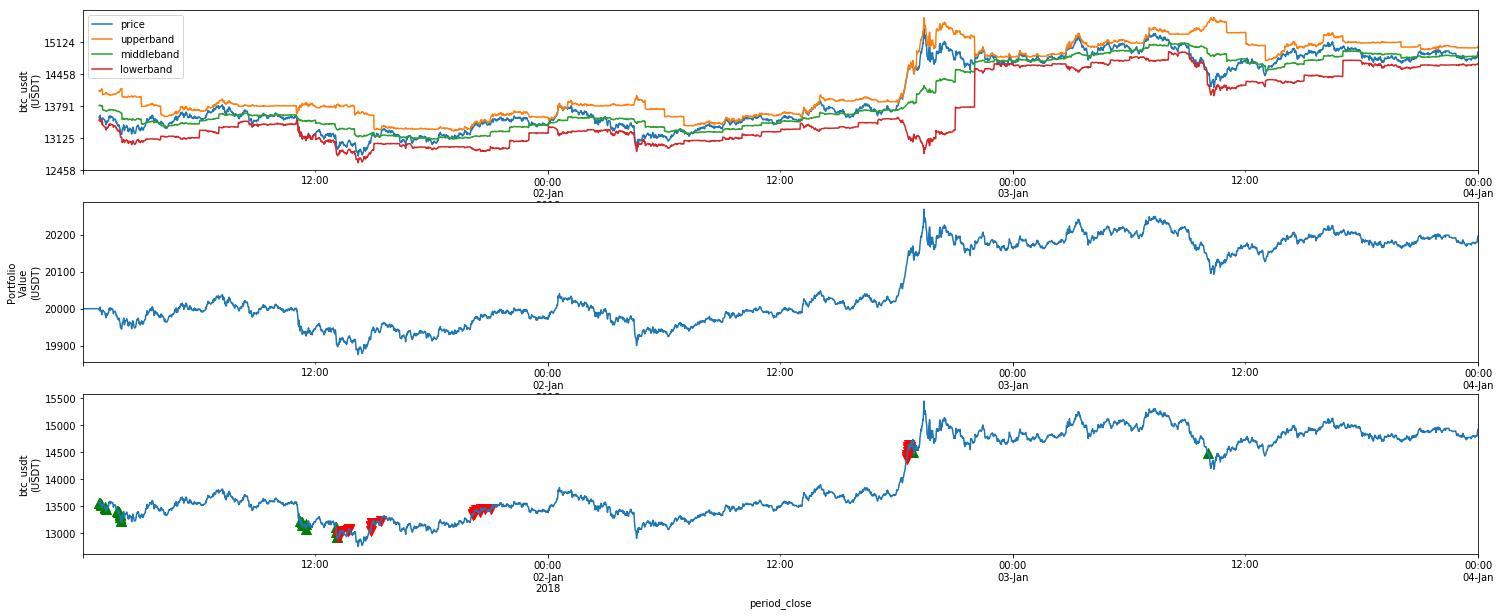

In [7]:
run_algorithm(
        capital_base=20000,
        data_frequency='minute',
        initialize=initialize,
        handle_data=handle_data,
        analyze=analyze,
        exchange_name='binance',
        algo_namespace=NAMESPACE,
        quote_currency='usdt',
        start=pd.to_datetime('2018-1-1', utc=True),
        end=pd.to_datetime('2018-1-3', utc=True),
    )